In [1]:
import torch
#import visdom
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn, optim
import time
import scipy.io as sio

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
def norm_trace(seis):
    data_out = np.zeros(np.shape(seis))
    for k in range(np.size(seis,axis=1)):
        data_out[:,k] = seis[:,k]/np.max(np.abs(seis[:,k]))
    seis=data_out
    return seis
def envelope(xr):
    for i in range(np.size(xr,axis=1)):
        hx = fftpack.hilbert(xr[:,i])
        xr[:,i] = np.sqrt(np.power(xr[:,i],2) + np.power(hx,2))
    return xr
def imagesc(damp,alpha=1):
    fig = plt.figure()
    plt.pcolormesh(damp, vmin=np.min(damp)*alpha, vmax=np.max(damp)*alpha,cmap= 'jet')
    ax = plt.gca() 
    ax.invert_yaxis() 
    plt.colorbar()
    matplotlib.cm.get_cmap('jet')
def extend_wave(s,nt):
    ng = np.size(s,axis=1)
    if np.size(s[:,0])<nt:
        ss=np.zeros((nt,ng))
        for i in range(ng):
            xr=np.zeros((nt))
            xr[0:np.size(s[:,0])]=s[:,i]
            ss[:,i]=xr
    return ss
def pad(p0, nbc, pad_top):
    p=np.concatenate((p0[:,0].reshape(-1,1).repeat(nbc,axis=1),p0,p0[:,-1].reshape(-1,1).repeat(nbc,axis=1)),axis=1)
    p=np.concatenate((p[0,:].reshape(1,-1).repeat(pad_top,axis=0),p,p[-1,:].reshape(1,-1).repeat(nbc,axis=0)),axis=0)
    return p

In [5]:
def a2d_mod_abc24_snap(vp_RM,nbc,dx,nt,dt,s,sx,sz,gx,gz,isFS,fr):
#  function [seis,wavefield]=a2d_mod_abc24_snap(v,nbc,dx,nt,dt,s,sx,sz,gx,gz,isFS,freq)
    vp_RMmin=torch.min(vp_RM)
    vp_RMmax=torch.max(vp_RM)
    fh = 20*fr
    gap = torch.fix((1/fh)/dt)  #1/20 个周期的情况下，  1/20 *T/dt
    n_snap = torch.fix(nt/gap)
    isnap = 0
    gap=int(gap)
    n_snap=int(n_snap)+1
   
    [nz,nx]=vp_RM.shape

#     wavefield.shape
    ng = gx.numel()
    ns = sx.numel()
    seis=torch.zeros((ns,nt,gx.numel()),device='cuda')
    wavefield = torch.zeros((ns,n_snap,nz,nx))
    c1 = -2.5; c2 = 4.0/3.0; c3 = -1.0/12.0; bc_len=3;
    vp_RM_nbc=vp_RM
    #扩展吸收边界=padvel
    absorb_left=vp_RM_nbc[:,[1]].repeat(1,nbc)
    vp_RM_nbc=torch.hstack((absorb_left,vp_RM_nbc))#组合
    absorb_right=vp_RM_nbc[:,[-1]].repeat(1,nbc)
    vp_RM_nbc=torch.hstack((vp_RM_nbc,absorb_right))
    absorb_top=vp_RM_nbc[[1],:].repeat(nbc,1)
    vp_RM_nbc=torch.vstack((absorb_top,vp_RM_nbc))
    absorb_down=vp_RM_nbc[[-1],:].repeat(nbc,1)
    vp_RM_nbc=torch.vstack((vp_RM_nbc,absorb_down))
    [nzbc,nxbc]=vp_RM_nbc.shape
    
    a=(nbc-1)*dx
    kappa = 3.0 * vp_RMmin * 16.118095650958320 / (2.0 * a)
    # setup 1D BC damping array
    damp1d=kappa*torch.pow(torch.arange(nbc,device='cuda')*dx/a,2)
    # setup 2D BC damping array
    damp=torch.zeros((nzbc,nxbc),device='cuda')
    # divide the whole area to 9 zones, and 5th is the target zone
    #  1   |   2   |   3
    #  ------------------
    #  4   |   5   |   6
    #  ------------------
    #  7   |   8   |   9
    # fulltill zone 1, 4, 7 and 3, 6, 9
    for iz in range(nzbc):
        damp[iz,0:nbc]=torch.flip(damp1d,dims=[0])
        damp[iz,nx+nbc:nx+2*nbc]=damp1d
    # full fill zone 2 and 8
    for ix in range(nbc,nbc+nx):
        damp[0:nbc,ix]=torch.flip(damp1d,dims=[0])
        damp[nbc+nz:nz+2*nbc,ix]=damp1d
    abc=damp
    alpha=torch.pow((vp_RM_nbc*dt/dx),2)#alpha 拓展边界后的速度场*dt；kappa
    kappa=abc*dt
    temp1 = torch.zeros((ns,nzbc,nxbc),device='cuda')
    temp2 = torch.zeros((ns,nzbc,nxbc),device='cuda')
    temp1=(2+2*c1*alpha-kappa).repeat(ns,1,1)
    temp2=(1-kappa).repeat(ns,1,1)
    beta_dt = torch.pow((vp_RM_nbc*dt),2)
    #s=expand_source(s,nt);
    #sx=1#临时
    #sz=1#临时
    #set and adjust the free surface position
    isx=(torch.round(sx/dx)+1+nbc).type(torch.int)
    isz=(torch.round(sz/dx)+1+nbc).type(torch.int)
    igx=(torch.round(gx/dx)+1+nbc).type(torch.int)
    igz=(torch.round(gz/dx)+1+nbc).type(torch.int)
    p1=torch.zeros((ns,nzbc,nxbc),device='cuda')
    p0=torch.zeros((ns,nzbc,nxbc),device='cuda')
    for it in range(nt):
        p=temp1*p1-temp2*p0+alpha \
            *(c2*(torch.roll(p1,1,2)+torch.roll(p1,-1,2)+torch.roll(p1,1,1)+torch.roll(p1,-1,1)) \
            +c3*(torch.roll(p1,2,2)+torch.roll(p1,-2,2)+torch.roll(p1,2,1)+torch.roll(p1,-2,1)))
        for ii in range(ns):
            p[ii,isz[ii],isx[ii]] = p[ii,isz[ii],isx[ii]] + beta_dt[isz[ii],isx[ii]] * s[it]
        if isFS==1:
            p[:,nbc,:]=0.0
            p[:,nbc-1:-1:nbc-2,:] = - p[:,nbc+1:nbc+2,:]

        for ig in range(ng):
            seis[:,it,ig]=p[:,igz[ig],igx[ig]]#记录第一层
#         print(seis.device)
#         print(p.device)
        if it%gap ==1:#一个gap记录一次
            wavefield[:,isnap,:,:] = p[:,nbc:nbc+nz,nbc:nbc+nx]
            isnap = isnap +1

        p0=p1
        p1=p
    return seis,wavefield
#######################################

In [6]:
#参数设置
# model1=torch.zeros([26,120])
# model1[0:12,:]=1000
# model1[12:26,:]=2500    #普通测试模型
model_list = sio.loadmat('model.mat')
vp_RM = torch.from_numpy(model_list['model35'].astype('float32'))
vp_RM.requires_grad_(False)
[nz,nx]=vp_RM.shape  #nz：深度网格点数，nx测线方向网格点数
x = torch.arange(nx)  # len = 10
y = torch.arange(nz)  # len = 6
X, Y = torch.meshgrid(x, y)
nbc=40                  #吸收边界长
dx=1                    #一网格点对应深度
dt=dx/torch.max(vp_RM)*0.5  #公式
torch.min(vp_RM)
nt=torch.floor(nx*dx/torch.min(vp_RM)/dt+300) #公式，不能过短
nt=int(nt)

#ricker
#[s,~]=ricker(fr,dt,nt)
fr=30              #频率
nw=2.2/fr/dt         #2.2？？？
nw=2*torch.floor(nw/2)+1
nc=torch.floor(nw/2)
k=torch.arange(1,nw,1)
alpha = (nc-k+1)*fr*dt*torch.pi
beta=alpha**2
w0 = (1.-beta**2)*torch.exp(-beta)  #ricker子波
s=torch.zeros((nt))
s[0:w0.numel()]=w0
########
ds=1
sx=torch.arange(0,nx,ds)
sz=torch.zeros(sx.shape)+1      #炮点位置
ns=sx.numel()
dg=1
gx=torch.arange(0,nx,dg)
ng=gx.numel()
gz=torch.zeros(gx.shape)+1
isFS=1

seismo_v_d=torch.zeros((ns,nt,ng)).to('cuda')

C:\Users\zc\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
for le in ['vp_RM','s','sx','sz','gx','gz']:
    print(le)
    exec(le + '=' + le + '.to("cuda:0")')

vp_RM
s
sx
sz
gx
gz


In [9]:
T1 = time.time()
seismo_v_d,wavefield_d=a2d_mod_abc24_snap(vp_RM,nbc,dx,nt,dt,s,sx,sz,gx,gz,isFS,fr)
T2 = time.time()
print('程序运行时间:%s秒' % ((T2 - T1)))

程序运行时间:213.25762724876404秒


In [ ]:
#中午测试180s，但无论如何在matlab同样的程序4核并行只要88s，还没有使用mex

In [12]:
!wmic cpu list brief

Caption                                DeviceID  Manufacturer  MaxClockSpeed  Name                                       SocketDesignation  

Intel64 Family 6 Model 158 Stepping 9  CPU0      GenuineIntel  2496           Intel(R) Core(TM) i5-7300HQ CPU @ 2.50GHz  U3E1               





In [10]:
!nvidia-smi

Sun May 15 23:07:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8     6W /  N/A |   1474MiB /  6144MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

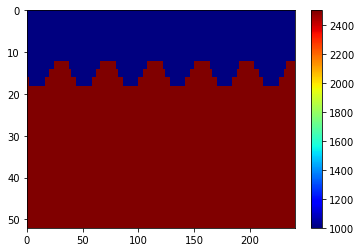

In [50]:
imagesc(vp_RM.detach().cpu().numpy())

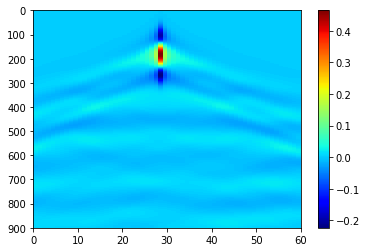

In [27]:
imagesc(seismo_v_d[7,:,:].detach().cpu().numpy().reshape(nt,ng))

In [188]:
ax = torch.tensor([r for r in range(1,25,2)])

In [211]:
slice(ax.type(torch.int))

ValueError: only one element tensors can be converted to Python scalars

In [210]:
aa[slice(ax),1] = ax

TypeError: only integer tensors of a single element can be converted to an index

In [343]:
aa = 1*torch.ones((26,220))
bb = 1*torch.ones((26,220),device='cuda')

In [333]:
@torch.jit.script
def mutiadd(xx,zz):
    return xx + zz

In [334]:
@torch.jit.script
def mutixx(xx):
    for i in range(100000):
        xx = xx*xx
    return xx

In [355]:
@torch.jit.script
def threadsafe(aa,oone):
    # launch compute_z asynchronously:
    fut = torch.jit._fork(mutixx, aa)
    # execute the next operation in parallel to compute_z:
    aa = aa + oone
    # wait for the result of compute_z:
    aa = torch.jit._wait(fut)
    aa = aa + oone
    return aa

In [356]:
threadsafe(aa,torch.ones((26,220)))

tensor([[2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        ...,
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.]])

In [354]:
aa = mutixx(aa)
aa

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [346]:
@torch.jit.script
def forward(bb,aa):
    # launch compute_z asynchronously:
    fut = torch.jit._fork(mutixx, bb)
    # execute the next operation in parallel to compute_z:
    aa = mutixx(aa)
    # wait for the result of compute_z:
    bb = torch.jit._wait(fut)
    return aa, bb

In [330]:
T1 = time.time()
forward(bb,aa)
T2 = time.time()
print('程序运行时间:%s秒' % ((T2 - T1)))

程序运行时间:0.36302781105041504秒


In [331]:
T1 = time.time()
bb = mutixx(bb)
T2 = time.time()
print('程序bb运行时间:%s秒' % ((T2 - T1)))
T1 = time.time()
aa = mutixx(aa)
T2 = time.time()
print('程序aa运行时间:%s秒' % ((T2 - T1)))
# !nvidia-smi

程序bb运行时间:0.24689888954162598秒
程序aa运行时间:0.36602115631103516秒


In [115]:
T1 = time.time()
for i in range(100000):
    bb*bb
    aa*aa
T2 = time.time()
print('程序运行时间:%s秒' % ((T2 - T1)))

程序运行时间:7.973886728286743秒


In [29]:
sx[i]

tensor(0, device='cuda:0')

In [53]:
i=0


In [57]:
import time
T1 = time.time()
seismo_v_d[i,:,:],wavefield_d=a2d_mod_abc24_snap(vp_RM,nbc,dx,nt,dt,s,sx[i],sz[i],gx,gz,isFS,fr)
# wavefield_d.to('cpu')
for j in range(1000000):
    aa*aa
T2 = time.time()
print('程序运行时间:%s秒' % ((T2 - T1)))

程序运行时间:12.350677490234375秒


In [58]:
import time
T1 = time.time()
seismo_v_d[i,:,:],wavefield_d=a2d_mod_abc24_snap(vp_RM,nbc,dx,nt,dt,s,sx[i],sz[i],gx,gz,isFS,fr)
# wavefield_d.to('cpu')
torch.cuda.synchronize()
T2 = time.time()
print('程序运行时间:%s秒' % ((T2 - T1)))

程序运行时间:8.399077415466309秒


In [ ]:

def func(a,b,c):
    return {"a":a,"b":b,"c":c}

def func2():
    
    ctx = torch.multiprocessing.get_context("spawn")
    print(torch.multiprocessing.cpu_count())
    pool = ctx.Pool(4) # 7.7G



    pool_list = []

    for XX:
        for XXX:
            for XXX:


                res = pool.apply_async(func, args=(a,b,c))
                pool_list.append(res)

    pool.close()  # 关闭进程池，不再接受新的进程
    pool.join()  # 主进程阻塞等待子进程的退出
    ccc = pd.DataFrame(columns=["a", "b", "c"])
    for i in pool_list:
        data = i.get()
        ccc = ccc.append(data, ignore_index=True)

In [ ]:
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.optim as optim
from torch.nn.parallel import DistributedDataParallel as DDP


def example(rank, world_size):
    # create default process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)
    # create local model
    model = nn.Linear(10, 10).to(rank)
    # construct DDP model
    ddp_model = DDP(model, device_ids=[rank])
    # define loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(ddp_model.parameters(), lr=0.001)

    # forward pass
    outputs = ddp_model(torch.randn(20, 10).to(rank))
    labels = torch.randn(20, 10).to(rank)
    # backward pass
    loss_fn(outputs, labels).backward()
    # update parameters
    optimizer.step()

def main():
    world_size = 2
    mp.spawn(example,
        args=(world_size,),
        nprocs=world_size,
        join=True)

if __name__=="__main__":
    # Environment variables which need to be
    # set when using c10d's default "env"
    # initialization mode.
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "29500"
    main()